In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
import prepare_ravinder
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
sns.set()
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
from sklearn.preprocessing import MinMaxScaler
# from imblearn.over_sampling import SMOTENC

# Load Data

In [2]:
df = pd.read_csv('data/training_v2.csv')
id_col = 'encounter_id'

df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
df_obj = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
cat_features = list(df_obj['Variable Name'].values)
for c in cat_features:
    if c not in df1.columns or c == 'hospital_death':
        cat_features.remove(c)
print(f'cat_features: {cat_features}')

cat_features: ['bmi', 'ethnicity', 'hospital_admit_source', 'icu_admit_type', 'icu_type', 'apache_2_diagnosis', 'apache_post_operative', 'gcs_unable_apache', 'ventilated_apache', 'cirrhosis', 'hepatic_failure', 'leukemia', 'solid_tumor_with_metastasis', 'apache_2_bodysystem']


In [3]:
df3 = pd.read_csv('data/training_v2.csv')

In [4]:
df3.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,1

In [5]:
df3[['apache_2_diagnosis','apache_3j_diagnosis', 'apache_3j_bodysystem', 'apache_2_bodysystem']].head(2)

,apache_2_diagnosis,apache_3j_diagnosis,apache_3j_bodysystem,apache_2_bodysystem
0,113.0,502.01,Sepsis,Cardiovascular
1,108.0,203.01,Respiratory,Respiratory


In [6]:
df[df.apache_3j_diagnosis == 0.01]

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
43183,8510,80667,100,0,57.0,24.579931,0,Caucasian,F,165.1,Direct Admit,Accident & Emergency,490,admit,Med-Surg ICU,0.01875,0,67.0,3.1,NaN,0.01,0,0.0,0.1,40.0,10.7,NaN,4.0,6.0,0.0,5.0,87.0,95.0,26.8,0.0,149.0,NaN,NaN,NaN,NaN,7.0,127.0,36.3,NaN,0.0,5.58,NaN,NaN,100.0,50.0,100.0,50.0,94.0,67.0,NaN,NaN,118.0,73.0,118.0,73.0,22.0,13.0,100.0,94.0,NaN,NaN,189.0,117.0,189.0,117.0,37.0,36.2,NaN,NaN,97.0,88.0,97.0,88.0,79.0,79.0,NaN,NaN,118.0,109.0,118.0,109.0,21.0,14.0,100.0,100.0,NaN,NaN,178.0,164.0,178.0,164.0,36.4,36.2,3.1,3.1,NaN,NaN,40.0,40.0,9.3,8.9,10.7,9.9379,88.0,87.0,25.0,24.0,10.2,9.5,28.6,26.8,1.07,1.07,0.9,0.9,258.0,240.0,4.0,3.6,129.0,127.0,6.49,5.58,3.1,3.1,NaN,NaN,40.0,40.0,9.3,9.3,10.2,10.2,87.0,87.0,25.0,25.0,10.2,10.2,28.6,28.6,1.07,1.07,0.9,0.9,258.0,258.0,3.6,3.6,129.0,129.0,6.49,6.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN


In [7]:
diagnosis_list = [102.01,
 501.05,
 403.01,
 104.01,
 501.02,
 212.01,
 502.01,
 203.01,
 501.06,
 401.01,
 106.01,
 107.01,
 206.01,
 501.04,
 501.01,
 901.03,
 211.09,
 305.02,
 410.01,
 601.01,
 211.03,
 101.01,
 1401.01,
 1404.01,
 305.01,
 212.02,
 207.01,
 409.02,
 109.09,
 202.01,
 204.01,
 201.01,
 306.01,
 407.01,
 704.01,
 1206.03,
 309.01,
 301.01,
 301.02,
 1502.02,
 1207.01,
 211.1,
 1501.01,
 402.02,
 211.02,
 802.01,
 109.1,
 703.03,
 1212.03,
 1410.01,
 601.06,
 111.01,
 103.01,
 311.01,
 702.01,
 108.01,
 211.12,
 109.03,
 211.08,
 701.02,
 601.05,
 211.04,
 402.01,
 1102.01,
 1904.01,
 208.01,
 601.04,
 405.01,
 1408.03,
 408.02,
 1302.02,
 105.02,
 1209.02,
 109.08,
 109.04,
 901.01,
 307.02,
 1204.02,
 1505.01,
 307.01,
 109.16,
 1205.01,
 1902.02,
 601.08,
 105.01,
 109.06,
 1406.01,
 1405.02,
 1601.01,
 110.01,
 1506.07,
 1202.07,
 603.01,
 213.01,
 310.01,
 109.14,
 801.04,
 312.05,
 1206.01,
 1210.01]

In [8]:
# df.apache_3j_diagnosis = np.where(df.apache_3j_diagnosis in diagnosis_list, df.apache_3j_diagnosis.astype(str), 'other')

In [9]:
for i in range(0, df.shape[0]):
    if df.apache_3j_diagnosis[i] in diagnosis_list:
        
        df.apache_3j_diagnosis[i] = str(df.apache_3j_diagnosis[i])
    else:
        df.apache_3j_diagnosis[i] = 'other'
    

In [10]:
df.apache_3j_diagnosis.value_counts()

other      15623
501.05      4480
107.01      4349
106.01      3923
403.01      3788
           ...  
501.05         1
403.01         1
1206.03        1
107.01         1
103.01         1
Name: apache_3j_diagnosis, Length: 110, dtype: int64

In [142]:
# df = df.drop([84436])
# df = df.drop([90742])
# df = df.drop([43183])

In [143]:
# df.apache_3j_diagnosis = df.apache_3j_diagnosis.astype(str)

In [144]:
df.ventilated_apache.isnull().sum()

715

In [11]:
df['gcs'] = df.gcs_eyes_apache + df.gcs_motor_apache + df.gcs_verbal_apache
df['almost_dead'] = np.where(((df.temp_apache <= 38) & ((df.ph_apache < 7.1) | (df.ph_apache < 7.3 )) & (df.temp_apache<35) |((df.ph_apache < 7.1 )) & (df.map_apache < 50) | ((df.ph_apache < 7.2 )) & (df.gcs < 5) | (df.pre_icu_los_days > 40)) | ((df.d1_lactate_max > 8) | (df.d1_lactate_min > 10)),True,False)
# df['almost_dead'] = np.where((df[((df.temp_apache <= 38) & ((df.ph_apache < 7.1) | (df.ph_apache < 7.3 )) & (df.temp_apache<35) |((df.ph_apache < 7.1 )) & (df.map_apache < 50) | ((df.ph_apache < 7.2 )) & (df.gcs < 5) | (df.pre_icu_los_days > 40)) | ((df.d1_lactate_max > 8) | (df.d1_lactate_min > 10)), True, False)
df['arterial_bp'] = np.where((df.d1_mbp_invasive_max.notnull()), True, False)
df['ventilated_apache'] = np.where(((df['ventilated_apache'].isnull()) & (df.h1_arterial_po2_min.notnull())), 1.0, df['ventilated_apache'])


# df['log_bmi'] = np.log2(df.bmi)

In [12]:
df['ventilated_apache'] = np.where((df['ventilated_apache'].isnull()), 0.0, df['ventilated_apache'])


In [13]:
df.almost_dead.sum()

2215

In [14]:
# df['almost_dead'] = np.where(((df.temp_apache <= 38) & ((df.ph_apache < 7.1) | (df.ph_apache < 7.3 )) & (df.temp_apache<35) |((df.ph_apache < 7.1 )) & (df.map_apache < 50) | ((df.ph_apache < 7.2 )) & (df.gcs < 5) | (df.pre_icu_los_days > 40)),True,False)


In [15]:
cardic_survived = df[df.apache_3j_diagnosis == 102.01][df.hospital_death == 0]
cardic_died = df[df.apache_3j_diagnosis == 102.01][df.hospital_death == 1]

In [16]:
cardic_survived[cardic_survived.ventilated_apache == 1].hospital_death.count()

0

In [17]:
cardic_survived[cardic_survived.ventilated_apache == 0].hospital_death.count()

0

In [18]:
cardic_died[cardic_died.ventilated_apache == 1].hospital_death.count()

0

In [19]:
cardic_died[cardic_died.ventilated_apache == 0].hospital_death.count()

0

In [155]:
cardic_died.gcs.mean()

4.5372993389990555

In [156]:
df[((df.temp_apache <= 37) & ((df.ph_apache < 7.1) | (df.ph_apache < 7.3 )) & (df.temp_apache<35) |((df.ph_apache < 7.1 )) & (df.map_apache < 50) | ((df.ph_apache < 7.2 )) & (df.gcs < 5) | (df.pre_icu_los_days > 40)) | ((df.d1_lactate_max > 8) | (df.d1_lactate_min > 10)) | (df.apache_3j_diagnosis==102.01) ].hospital_death.value_counts()



1    2024
0    1801
Name: hospital_death, dtype: int64

In [22]:
inv = [s for s in df.columns.tolist() if "invasive" in s]

In [23]:
df['ventilated_apache'].value_counts()

0.0    61981
1.0    29729
Name: ventilated_apache, dtype: int64

In [24]:
df[(df.d1_mbp_invasive_max.notnull())].hospital_death.value_counts()

0    20912
1     3023
Name: hospital_death, dtype: int64

In [25]:
df[df.d1_mbp_invasive_max.isnull()].hospital_death.value_counts()

0    62883
1     4892
Name: hospital_death, dtype: int64

In [26]:
df[df['ventilated_apache'].isnull()][(df.d1_arterial_po2_min.notnull()) | (df.pre_icu_los_days>2)].hospital_death.value_counts()

Series([], Name: hospital_death, dtype: int64)

In [27]:
df[df['ventilated_apache'].isnull()].hospital_death.value_counts()

Series([], Name: hospital_death, dtype: int64)

In [28]:
df[df['ventilated_apache'].notnull()][df.h1_arterial_po2_min.notnull()].hospital_death.value_counts()

0    13502
1     2265
Name: hospital_death, dtype: int64

In [29]:
df[df['ventilated_apache'].isnull()][df.h1_arterial_po2_min.notnull()].hospital_death.value_counts()

Series([], Name: hospital_death, dtype: int64)

In [30]:
df[df['ventilated_apache'].notnull()][df.hospital_death == 1][df.d1_diasbp_invasive_min.notnull()]

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs,almost_dead,arterial_bp
8,80471,10577,118,1,45.0,NaN,0,Caucasian,M,170.2,Other Hospital,Other Hospital,114,admit,CCU-CTICU,0.009028,0,NaN,2.7,116.0,103.01,0,0.0,0.2,15.0,1.16,1.0,4.0,6.0,0.0,5.0,380.0,82.0,37.9,0.0,66.0,60.0,60.0,92.0,7.14000,14.0,142.0,36.9,NaN,1.0,24.70,64.0,52.0,65.0,59.0,65.0,59.0,82.0,82.0,72.0,66.0,93.0,71.0,93.0,71.0,24.0,19.0,97.0,97.0,94.0,72.0,104.0,98.0,104.0,98.00,36.9,36.9,64.0,52.0,65.0,59.0,65.0,59.0,82.0,82.0,72.0,66.0,93.0,71.0,93.0,71.0,24.0,19.0,97.0,97.0,94.0,72.0,104.0,98.0,104.0,98.0,36.9,36.9,2.7,2.7,0.2,0.2,15.0,15.0,7.3,7.3,1.16,1.16,365.0,288.0,23.0,23.0,12.3,12.3,37.9,37.9,1.2,1.2,5.9,5.9,226.0,226.0,5.2,5.2,142.0,142.0,24.70,24.70,2.7,2.7,0.2,0.2,15.0,15.0,7.3,7.3,1.16,1.16,365.0,365.0,23.0,23.0,12.3,12.3,37.9,37.9,1.2,1.2,5.9,5.9,226.0,226.0,5.2,5.2,142.0,142.0,24.7,24.7,60.0,33.0,7.620,6.99,256.0,92.0,92.000000,92.000000,60.0,60.0,7.14,7.14,92.0,92.0,92.0,92.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardi

In [31]:
df[df['ventilated_apache'].isnull()][df.hospital_death == 0].pre_icu_los_days.mean()

nan

In [32]:
for i in inv:
    print(i)
    print(df[i].notnull().sum())

d1_diasbp_invasive_max
23728
d1_diasbp_invasive_min
23728
d1_diasbp_noninvasive_max
90670
d1_diasbp_noninvasive_min
90670
d1_mbp_invasive_max
23935
d1_mbp_invasive_min
23935
d1_mbp_noninvasive_max
90231
d1_mbp_noninvasive_min
90231
d1_sysbp_invasive_max
23753
d1_sysbp_invasive_min
23753
d1_sysbp_noninvasive_max
90683
d1_sysbp_noninvasive_min
90683
h1_diasbp_invasive_max
16784
h1_diasbp_invasive_min
16784
h1_diasbp_noninvasive_max
84361
h1_diasbp_noninvasive_min
84361
h1_mbp_invasive_max
16868
h1_mbp_invasive_min
16868
h1_mbp_noninvasive_max
82627
h1_mbp_noninvasive_min
82627
h1_sysbp_invasive_max
16797
h1_sysbp_invasive_min
16797
h1_sysbp_noninvasive_max
84370
h1_sysbp_noninvasive_min
84370


In [33]:
df.shape

(91710, 189)

In [34]:
df1.head(2)

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient unit stay,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None


In [20]:
df['bool_'+ 'h1_lactate_max'] = np.where(pd.notnull(df['h1_lactate_max']), True, False)

# Drop non_useful features

In [21]:
# columns missing a lot of data. We we instead create a boolean column which will indicate if the data is missing or not

missing = ['h1_bilirubin_max', 'h1_lactate_max',
       'h1_lactate_min', 'h1_albumin_max',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_max',
       'h1_arterial_ph_min', 'h1_hco3_max',
       'h1_arterial_pco2_max', 'h1_arterial_pco2_min', 'h1_wbc_max',
       'h1_arterial_po2_min', 'h1_arterial_po2_max',
       'h1_calcium_max', 'h1_calcium_min', 
       'h1_platelets_max', 'h1_bun_max', 'h1_creatinine_max',
       'h1_hematocrit_min', 'h1_hematocrit_max',
       'h1_hemaglobin_min', 'h1_hemaglobin_max', 'h1_sodium_max',
       'h1_sodium_min', 'h1_potassium_min', 'h1_potassium_max']

In [22]:
to_remove=['icu_id','patient_id','encounter_id','apache_4a_hospital_death_prob' ] + missing


In [23]:
# df['apache_death_prob'] = np.where(df['apache_4a_hospital_death_prob'] >= df['apache_4a_icu_death_prob'], df['apache_4a_hospital_death_prob'],df['apache_4a_icu_death_prob'])
# 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'

In [24]:
# df_n = df[df.apache_2_diagnosis.notnull()]
# df_n.head(2)

In [25]:
diagnosis = df.apache_2_diagnosis.value_counts().index
diagnosis = diagnosis.astype(str)

In [26]:
apache = [
 'age',
 'bmi',
 'height',
 'weight',
 'albumin_apache',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache',
 ]

In [27]:
# create a empty dataframe (with NaNs)
df_ = pd.DataFrame(index=apache, columns= diagnosis)
df_.head(2)

,113.0,301.0,302.0,112.0,308.0,117.0,124.0,122.0,303.0,110.0,304.0,203.0,202.0,106.0,305.0,114.0,121.0,123.0,102.0,307.0,119.0,120.0,118.0,108.0,214.0,109.0,105.0,213.0,207.0,306.0,218.0,217.0,209.0,219.0,101.0,104.0,103.0,115.0,116.0,107.0,215.0,208.0,212.0,216.0
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
for d in diagnosis:
    for a in apache:
        df_[d][a] = df[df.apache_2_diagnosis == float(d)][a].mean()
        
for a in apache:
    for d in diagnosis:
        df['diff_'+ a] = np.where(df[a].notnull(), df_[d][a]-df[a], 0)

In [29]:
for a in apache:
    for d in diagnosis:
        df['diff_'+ a] = np.where(df[a].notnull(), df_[d][a]-df[a], 0)

In [30]:
df.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,...,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs,almost_dead,arterial_bp,bool_h1_lactate_max,diff_age,diff_bmi,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_ventilated_apache,diff_wbc_apache
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,...,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [31]:
features = [col for col in df.columns]

In [32]:
def drop_correlated_features(df):
    df1 = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')
    df1 = df1[(df1['Data Type'] == 'string') | (df1['Data Type'] == 'binary')]
    cat_features = list(df1['Variable Name'].values)
    for c in cat_features:
        if c not in df1.columns or c == 'hospital_death':
            cat_features.remove(c)

    num_feature = [col for col in features if col not in cat_features and df[col].dtype != 'object']
    drop_columns=[]
    corr = df[num_feature].corr()



    columns = np.full((corr.shape[0],), True, dtype=bool)

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >=0.99 :
                if columns[j] == True:
                    columns[j] = False
                    print('col1: {} col2: {} - Correlation: {}'.format(df[num_feature].columns[i] , df[num_feature].columns[j], corr.iloc[i,j]))
            elif corr.iloc[i,j] <= -0.99:
                if columns[j] == True:
                    columns[j] = False

    drop_columns = df[num_feature].columns[columns == False].values
    return drop_columns

In [33]:
drop_columns = drop_correlated_features(df)

col1: bilirubin_apache col2: d1_bilirubin_max - Correlation: 0.9965677029378415
col1: creatinine_apache col2: d1_creatinine_max - Correlation: 0.9938024247389716
col1: paco2_apache col2: paco2_for_ph_apache - Correlation: 1.0
col1: d1_diasbp_max col2: d1_diasbp_noninvasive_max - Correlation: 0.9978312339594645
col1: d1_diasbp_min col2: d1_diasbp_noninvasive_min - Correlation: 0.9968714632425789
col1: d1_mbp_min col2: d1_mbp_noninvasive_min - Correlation: 0.9955315558446697
col1: d1_sysbp_max col2: d1_sysbp_noninvasive_max - Correlation: 0.996559679816597
col1: d1_sysbp_min col2: d1_sysbp_noninvasive_min - Correlation: 0.9963220900474754
col1: h1_mbp_min col2: h1_mbp_noninvasive_min - Correlation: 0.9966727876843414
col1: h1_sysbp_max col2: h1_sysbp_noninvasive_max - Correlation: 0.9963772107865891
col1: d1_inr_max col2: h1_inr_max - Correlation: 1.0
col1: d1_inr_min col2: h1_inr_min - Correlation: 1.0
col1: h1_albumin_max col2: h1_albumin_min - Correlation: 0.9997274157107932
col1: h1_

In [34]:
drop_columns

array(['paco2_for_ph_apache', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max',
       'd1_bilirubin_max', 'd1_creatinine_max', 'h1_albumin_min',
       'h1_bilirubin_min', 'h1_bun_min', 'h1_creatinine_min',
       'h1_hco3_min', 'h1_inr_max', 'h1_inr_min', 'h1_platelets_min',
       'h1_wbc_min', 'diff_age', 'diff_height', 'diff_weight',
       'diff_albumin_apache', 'diff_arf_apache', 'diff_bilirubin_apache',
       'diff_bun_apache', 'diff_creatinine_apache', 'diff_fio2_apache',
       'diff_glucose_apache', 'diff_heart_rate_apache',
       'diff_hematocrit_apache', 'diff_intubated_apache',
       'diff_map_apache', 'diff_paco2_apache', 'diff_pao2_apache',
       'diff_ph_apache', 'diff_resprate_apache', 'diff_sodium_apache',
       'diff_temp_apache', 'diff_urineoutput_apache', 'diff_wbc_apache'],
      dtype=object)

In [35]:
features = [col for col in features if col not in drop_columns]

In [36]:
df = df[features]
inv_cols=[s for s in df.columns.tolist() if "invasive" in s]
df.drop(inv_cols,axis=1,inplace=True)

In [37]:
df['icu_type']=df['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})

df['hospital_admit_source']= df['hospital_admit_source'].replace({
                                        'Other ICU':"ICU",'ICU to SDU':"SDU",
                                       'Step-Down Unit (SDU)':"SDU",
                                      'Acute Care/Floor':"Floor",
                                      'Other Hospital':"Other"})


binary=[col for col in df.columns if df[col].nunique() == 2 and df[col].dtypes !='object']
categorical = [col for col in df.columns if df[col].dtypes == 'object']
# df['apache_3j_diagnosis']= df['apache_3j_diagnosis'].fillna(0).astype(np.int64)
df['apache_2_diagnosis']= df['apache_2_diagnosis'].fillna(0).astype(np.int64)
categorical.append('apache_2_diagnosis')
# categorical.append('apache_3j_diagnosis')

In [38]:
for col in binary:
    df[col]= df[col]+1
    df[col].fillna(0,inplace=True)
    df[col]= df[col].astype(np.int8).astype('category')

In [39]:
df['gcs_unable_apache'] = df['gcs_unable_apache'].astype('Int64')
for b in binary:
    df[b] = df[b].astype('Int64')

In [40]:
df.shape

(91713, 156)

In [41]:
df.hospital_death.value_counts()

1    83798
2     7915
Name: hospital_death, dtype: Int64

In [42]:
numeric_col =[col for col in df.columns if  df[col].dtypes !='object' and col not in binary]

In [43]:
redundant_features = ['readmission_status', 'apache_2_bodysystem']

In [44]:
df.drop(columns = redundant_features, inplace = True)

In [45]:
numeric_col.remove('readmission_status')
numeric_col.remove('apache_2_diagnosis')
# numeric_col.remove('apache_3j_diagnosis')
# numeric_col.remove('log_bmi')
categorical.remove('apache_2_bodysystem')
categorical.remove('icu_stay_type')
categorical.remove('apache_2_diagnosis')
# categorical.remove('apache_3j_diagnosis')

In [46]:
categorical

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_type',
 'apache_3j_diagnosis',
 'apache_3j_bodysystem']

In [47]:
binary

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'almost_dead',
 'arterial_bp',
 'bool_h1_lactate_max',
 'diff_ventilated_apache']

In [48]:
df.shape

(91713, 154)

In [49]:
train, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [50]:
# create a empty dataframe (with NaNs)
train_ = pd.DataFrame(index=apache, columns= diagnosis)
train_.head(2)
# create a empty dataframe (with NaNs)
test_ = pd.DataFrame(index=apache, columns= diagnosis)
test_.head(2)

,113.0,301.0,302.0,112.0,308.0,117.0,124.0,122.0,303.0,110.0,304.0,203.0,202.0,106.0,305.0,114.0,121.0,123.0,102.0,307.0,119.0,120.0,118.0,108.0,214.0,109.0,105.0,213.0,207.0,306.0,218.0,217.0,209.0,219.0,101.0,104.0,103.0,115.0,116.0,107.0,215.0,208.0,212.0,216.0
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
for d in diagnosis:
    for a in apache:
        train_[d][a] = train[train.apache_2_diagnosis == float(d)][a].mean()
        
for a in apache:
    for d in diagnosis:
        train['diff_'+ a] = np.where(train[a].notnull(), train_[d][a] - train[a], 0)

In [52]:
for d in diagnosis:
    for a in apache:
        test_[d][a] = test[test.apache_2_diagnosis == float(d)][a].mean()
        
for a in apache:
    for d in diagnosis:
        test['diff_'+ a] = np.where(test[a].notnull(), test_[d][a] - test[a], 0)

In [53]:
features = [col for col in train.columns if col not in to_remove]
# redundant_features = ['readmission_status', 'apache_2_bodysystem', 'apache_2_diagnosis', 'apache_3j_diagnosis'] + missing
# train.drop(columns = redundant_features, inplace = True)

In [54]:
train = train[features]
test = test[features]

In [55]:
# test.drop(columns = features, inplace = True)

In [56]:
numeric_col =[col for col in train.columns if  train[col].dtypes !='object' and col not in binary]

In [57]:
# numeric_col.remove('readmission_status')
# numeric_col.remove('apache_2_diagnosis')
# numeric_col.remove('apache_3j_diagnosis')
# categorical.remove('apache_2_bodysystem')
# categorical.remove('icu_stay_type')
# categorical.remove('apache_2_diagnosis')
# categorical.remove('apache_3j_diagnosis')
numeric_col.remove('hospital_id')
categorical.append('hospital_id')

In [58]:
train.head(2)

,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,gcs,almost_dead,arterial_bp,bool_h1_lactate_max,diff_bmi,diff_ventilated_apache,diff_age,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_wbc_apache
59226,176,2,72.0,32.041330,1,Caucasian,F,154.9,SDU,Floor,admit,MICU,0.061111,76.88,2.0,113,501.02,1,1,2.4,26.0,1.64,NaN,4.0,6.0,1,4.0,107.0,99.0,27.9,1,45.0,NaN,NaN,NaN,13.0,135.0,36.6,NaN,1,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.7,35.8,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11,1,1,1,1,1,1,1,2,Sepsis,14.0,1,1,1,-5.494076,0.217391,-18.565217,13.202609,-1.656667,1.1,0.565217,-1.411111,16.913043,3.87,0.0,78.956522,-10.434783,0.204348,0.130435,65.217391,0.0,0.0,0.0,11.173913,2.956522,-0.146957,0.0,-10.286087
81334,18,1,58.0,34.334291,1,Caucasian,M,190.5,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,0.032639,124.60,2.5,113,501.01,1,1,1.2,70.0,2.85,NaN,1.0,1.0,1,1.0,319.0,138.0,37.4,1,47.0,NaN,NaN,NaN,53.0,117.0,36.2,NaN,2,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.8,36.2,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.8,37.4,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53,1,1,2,1,1,1,1,1,Sepsis,3.0,1,1,1,-7.787036,-0.782609,-4.565217,-22.397391,-49.376667,0.6,0.565217,-0.211111,-27.086957,2.66,0.0,-133.043478,-49.434783,-9.295652,0.130435,63.217391,0.0,0.0,0.0,-28.826087,20.956522,0.253043,0.0,-3.676087


## Imputation
Imputation was done based on the type of variable it was. Broadly, there are numerical and categorical variables.

### Numerical variables

In [59]:
numeric_df = train[numeric_col]
numeric_df_test = test[numeric_col]
numeric_df.head(3)

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,apache_4a_icu_death_prob,gcs,diff_bmi,diff_age,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_wbc_apache
59226,72.0,32.041330,154.9,0.061111,76.88,2.0,113,2.4,26.0,1.64,NaN,4.0,6.0,4.0,107.0,99.0,27.9,45.0,NaN,NaN,NaN,13.0,135.0,36.60,NaN,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.70,35.80,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11,14.0,-5.494076,-18.565217,13.202609,-1.656667,1.1,0.565217,-1.411111,16.913043,3.87,0.0,78.956522,-10.434783,0.204348,0.130435,65.217391,0.0,0.0,0.0,11.173913,2.956522,-0.146957,0.0,-10.286087
81334,58.0,34.334291,190.5,0.032639,124.60,2.5,113,1.2,70.0,2.85,NaN,1.0,1.0,1.0,319.0,138.0,37.4,47.0,NaN,NaN,NaN,53.0,117.0,36.20,NaN,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.80,36.20,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.80,37.40,2.6,2.5,1.0,70.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,123.0,152.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53,3.0,-7.787036,-4.565217,-22.397391,-49.376667,0.6,0.565217,-0.211111,-27.086957,2.66,0.0,-133.043478,-49.434783,-9.295652,0.130435,63.217391,0.0,0.0,0.0,-28.826087,20.956522,0.253043,0.0,-3.676087
67173,78.0,32.764004,165.0,2.527083,89.20,NaN,218,NaN,NaN,NaN,NaN,3.0,6.0,5.0,NaN,41.0,NaN,63.0,NaN,NaN,NaN,12.0,NaN,36.33,NaN,NaN,108.0,44.0,70.0,44.0,116.0,63.0,20.0,12.0,98.0,91.0,149.0,104.0,37.22,36.33,85.0,64.0,53.0,50.0,85.0,85.0,18.0,13.0,97.0,97.0,138.0,125.0,37.22,36.44,NaN,NaN,NaN,12.0,12.0,NaN,NaN,0.56,115.0,115.0,23.0,23.0,13.7,13.7,40.7,40.7,NaN,NaN,NaN,NaN,164.0,164.0,4.4,4.4,141.0,141.0,7.59,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,14.0,-6.216749,-24.565217,3.102609,-13.976667,0.0,0.565217,0.000000,0.000000,0.00,0.0,0.000000,47.565217,0.000000,0.130435,47.217391,0.0,0.0,0.0,12.173913,0.000000,0.123043,0.0,0.000000


In [60]:
binary_df = train[binary]
binary_df_test = test[binary]


binary_df.head(3)

,hospital_death,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,almost_dead,arterial_bp,bool_h1_lactate_max,diff_ventilated_apache
59226,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,0.217391
81334,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1,-0.782609
67173,1,2,2,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,0.217391


In [61]:
categorical_df = train[categorical]
categorical_df_test = test[categorical]
categorical_df.isnull().sum()

ethnicity                 1123
gender                      19
hospital_admit_source    17227
icu_admit_source            92
icu_type                     0
apache_3j_diagnosis          0
apache_3j_bodysystem      1346
hospital_id                  0
dtype: int64

In [62]:
# from sklearn.experimental import enable_iterative_imputer  
# from sklearn.impute import IterativeImputer
# # from sklearn.impute import KNNImputer


In [63]:
# imp = IterativeImputer(max_iter=3, verbose=0)
# imp.fit(numeric_df)
# imputed_df = imp.transform(numeric_df)
# imputed_df = pd.DataFrame(imputed_df, columns=numeric_df.columns, index = numeric_df.index)

In [64]:
# impt = IterativeImputer(max_iter=3, verbose=0)
# impt.fit(numeric_df_test)
# imputed_df_test = impt.transform(numeric_df_test)
# imputed_df_test = pd.DataFrame(imputed_df_test, columns=numeric_df_test.columns, index = numeric_df_test.index)

In [65]:
for col in categorical:
    categorical_df[col].fillna(categorical_df[col].mode()[0],inplace=True)

In [66]:
for col in categorical:
    categorical_df_test[col].fillna(categorical_df_test[col].mode()[0],inplace=True)

In [67]:
# imputed_df.head(2)

In [68]:
# imputed_df.shape, imputed_df_test.shape

In [69]:
# scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_df)

# numeric_df_scaled = pd.DataFrame(scaler.transform(numeric_df), columns=numeric_df.columns.values).set_index([numeric_df.index.values])


In [70]:
# numeric_df_scaled

In [71]:
# scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(imputed_df)

# imputed_df_scaled = pd.DataFrame(scaler.transform(imputed_df), columns=imputed_df.columns.values).set_index([imputed_df.index.values])


scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_df)


numeric_df_scaled = pd.DataFrame(scaler.transform(numeric_df), columns=numeric_df.columns.values).set_index([numeric_df.index.values])




In [72]:
# scaler1 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(imputed_df_test)

# imputed_df_test_scaled = pd.DataFrame(scaler1.transform(imputed_df_test), columns=imputed_df_test.columns.values).set_index([imputed_df_test.index.values])

scaler1 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_df_test)

numeric_df_test_scaled = pd.DataFrame(scaler1.transform(numeric_df_test), columns=numeric_df_test.columns.values).set_index([numeric_df_test.index.values])



In [73]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 117), (73370, 8), (73370, 19))

# Encoding

## Label encoding


In [74]:
categorical_df.dtypes

ethnicity                object
gender                   object
hospital_admit_source    object
icu_admit_source         object
icu_type                 object
apache_3j_diagnosis      object
apache_3j_bodysystem     object
hospital_id               int64
dtype: object

In [75]:
categorical_df.apache_3j_bodysystem.value_counts()

Cardiovascular          25284
Neurological             9576
Sepsis                   9395
Respiratory              9283
Gastrointestinal         7220
Metabolic                6101
Trauma                   3084
Genitourinary            1740
Musculoskeletal/Skin      936
Hematological             503
Gynecological             248
Name: apache_3j_bodysystem, dtype: int64

## One hot encoding

In [76]:
from sklearn.preprocessing import OneHotEncoder

In [77]:
categorical_df.columns

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_type', 'apache_3j_diagnosis', 'apache_3j_bodysystem',
       'hospital_id'],
      dtype='object')

In [78]:
binary_df.drop(columns=['hospital_death'], inplace = True)
binary_df_test.drop(columns=['hospital_death'], inplace = True)

In [79]:
l = ['ethnicity','gender','hospital_admit_source', 'icu_admit_source','icu_type', 'apache_3j_bodysystem',
 'apache_3j_diagnosis',
     'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [80]:
train1 = pd.concat([categorical_df, binary_df], axis =1)
test1 = pd.concat([categorical_df_test, binary_df_test], axis =1)

In [81]:
train1.head(2)

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_type,apache_3j_diagnosis,apache_3j_bodysystem,hospital_id,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,almost_dead,arterial_bp,bool_h1_lactate_max,diff_ventilated_apache
59226,Caucasian,F,SDU,Floor,MICU,501.02,Sepsis,176,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,0.217391
81334,Caucasian,M,Direct Admit,Accident & Emergency,Med-Surg ICU,501.01,Sepsis,18,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1,-0.782609


In [86]:
train1.apache_3j_diagnosis = train1.apache_3j_diagnosis.astype(str)
test1.apache_3j_diagnosis = test1.apache_3j_diagnosis.astype(str)

In [87]:
train1 = prepare_ravinder.encode(train1, l)
test1 = prepare_ravinder.encode(test1, l)

In [88]:
numeric_df.shape, categorical_df.shape, binary_df.shape

((73370, 117), (73370, 8), (73370, 18))

In [89]:
# imputed_df.shape, categorical_df.shape, binary_df.shape

In [90]:
# train = pd.concat([imputed_df_scaled ,train1], axis =1)
# test = pd.concat([imputed_df_test_scaled ,test1], axis =1)

train = pd.concat([numeric_df_scaled ,train1], axis =1)
test = pd.concat([numeric_df_test_scaled ,test1], axis =1)



# train

In [91]:
binary

['hospital_death',
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'almost_dead',
 'arterial_bp',
 'bool_h1_lactate_max',
 'diff_ventilated_apache']

# Modeling

## Baseline

## Logist regression

### Building a Model

In [92]:
# from sklearn.linear_model import LogisticRegression

In [93]:
# param = ['height',
#  'temp_apache',
#  'd1_diasbp_max',
#  'd1_diasbp_min',
#  'd1_heartrate_max',
#  'd1_heartrate_min',
#  'd1_mbp_max',
#  'd1_mbp_min',
#  'd1_spo2_max',
#  'd1_spo2_min',
#  'd1_sysbp_max',
#  'd1_sysbp_min',
#  'd1_temp_max',
#  'd1_temp_min']
# for p in param:  
#     complet_df['bool_'+ p] = np.where(pd.notnull(complet_df[p]), 1,0)

In [94]:
train2, test2 = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [95]:
y = train2[['hospital_death']]
y['hospital_death'] = y['hospital_death']-1
X = train

y_test = test2[['hospital_death']]
y_test['hospital_death'] = y_test['hospital_death']-1
X_test = test

In [96]:
y['hospital_death'] = y['hospital_death'].astype(int)
y_test['hospital_death'] = y_test['hospital_death'].astype(int)

In [97]:
X.shape, y.shape

((73370, 303), (73370, 1))

In [98]:
# from sklearn.model_selection import GridSearchCV
# from sklearn import svm
# # pipe = Pipeline([('classifier')])
# # pipe = Pipeline([('classifier', RandomForestClassifier())])

# # Create param grid.
# logistic = LogisticRegression()

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-2, 2, 20),
#     'classifier__solver' : ['liblinear']}
# ]

# # Create grid search object

# clf = GridSearchCV('logistic', param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(X, y)

In [ ]:
# logit = LogisticRegression(C = 100.0, class_weight = 'balanced',penalty = 'l2', max_iter=1000)
# logit.fit(X, y)

In [ ]:
# y_pred = logit.predict(X)

In [ ]:
# y_pred_test = logit.predict(X_test)

In [ ]:
# feature_imp = pd.DataFrame(logit.coef_[0], index = X.columns).reset_index()

In [ ]:
# feature_imp.columns = ['feature', 'coeff']
# feature_imp.sort_values('coeff').head(199)

In [ ]:
# feature_imp.to_csv('data/feature_imp.csv')

### AUC Roc score

In [ ]:
# plt.figure(figsize=(10,6))

# y_pred = logit.predict_proba(X)[:,1]
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))

# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [ ]:
# plt.figure(figsize=(10,6))

# y_pred_test = logit.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         


# # y_pred = knn.predict_proba(X_validate_scaled)[:,1]
# # fpr, tpr, thresholds = roc_curve(y_validate, y_pred)
# # plt.plot(fpr, tpr, color='yellow', lw=3, label='KNN (area = %0.2f)' % auc(fpr, tpr))


# # y_pred_test = rf.predict_proba(X_test)[:,1]
# # fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
# # plt.plot(fpr, tpr, color='brown', lw=2, label='RandomForest (area = %0.2f)' % auc(fpr, tpr))

# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [ ]:
# idx = []
# for i in range(101, 183):
#     idx.append(i)

In [ ]:
# sm = SMOTENC(random_state=42, categorical_features = idx)
# x_train_res, y_train_res = sm.fit_sample(X, y)
# print (Y_train.value_counts() , np.bincount(y_train_res))

In [ ]:
# logit = LogisticRegression(C = .01, class_weight = 'balanced',penalty = 'l2', max_iter=1000)
# logit.fit(x_train_res, y_train_res)

In [ ]:
# plt.figure(figsize=(10,6))

# y_pred = logit.predict_proba(x_train_res)[:,1]
# fpr, tpr, thresholds = roc_curve(y_train_res, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [ ]:
# plt.figure(figsize=(10,6))

# y_pred = logit.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

## Decision Tree

### Building a model

In [ ]:
# from sklearn.tree import DecisionTreeClassifier


In [ ]:
# dt = DecisionTreeClassifier(max_depth=8, random_state=42, class_weight={1:2})
# dt.fit(X, y)

In [ ]:
# rf = RandomForestClassifier(bootstrap=True, 
#                             class_weight= "balanced" , 
#                             criterion='gini',
#                             min_samples_leaf=10,
#                             n_estimators=100,
#                             max_depth=8, 
#                             random_state=123)

In [ ]:
# rf.fit(X, y)

In [ ]:
# plt.figure(figsize=(10,6))

# y_pred = rf.predict_proba(X)[:,1]
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='RF Train (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [ ]:
# plt.figure(figsize=(10,6))

# y_pred = rf.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='RF Test (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [99]:
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV
# from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [100]:
X['almost_dead'] = X['almost_dead'].astype(np.float64)
X['bool_h1_lactate_max'] = X['bool_h1_lactate_max'].astype(np.float64)
X_test['almost_dead'] = X_test['almost_dead'].astype(np.float64)
X_test['bool_h1_lactate_max'] = X_test['bool_h1_lactate_max'].astype(np.float64)
X['arterial_bp'] = X['arterial_bp'].astype(np.float64)
X_test['arterial_bp'] = X_test['arterial_bp'].astype(np.float64)


In [101]:
# def modelfit(alg, dtrain, y ,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(X.values, label= y.values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(X, y['hospital_death'],eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(X)
#     dtrain_predprob = alg.predict_proba(X)[:,1]
        
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(y['hospital_death'].values, dtrain_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(y['hospital_death'], dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [102]:
# xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed= 42)
# modelfit(xgb1, X, y)

In [103]:
param_test1 = {
 'max_depth':range(5,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=5, gamma=0.25, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X,y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [104]:
param_test2 = {
 'max_depth':[6,7,8],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=7,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X,y)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [105]:
# param_test3 = {
#  'gamma':[i/10.0 for i in range(0,5)]
# }
# gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
#  min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch3.fit(X,y)
# gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

In [106]:
# param_test4 = {
#  'subsample':[i/10.0 for i in range(6,10)],
#  'colsample_bytree':[i/10.0 for i in range(6,10)]
# }
# gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=7,
#  min_child_weight=5, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
#  param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
# gsearch4.fit(X,y)
# gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

In [107]:
# X.columns.to_list()

In [145]:
model = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=7,
 min_child_weight=5, gamma=0.25, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, reg_alpha=0.0001, seed=27)
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.0001, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [146]:
y_pred = model.predict(X)

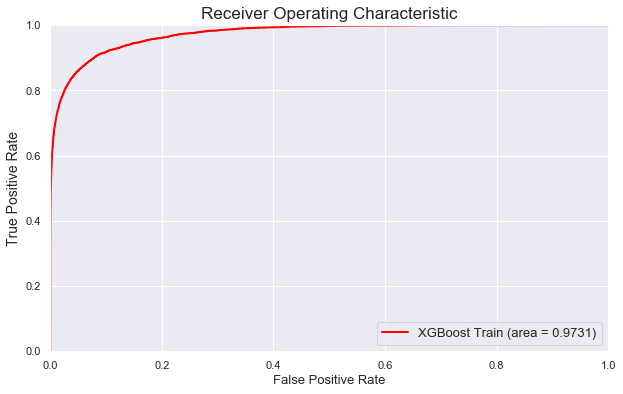

In [147]:
plt.figure(figsize=(10,6))

y_pred = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='XGBoost Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()


In [150]:
X.shape

(73370, 187)

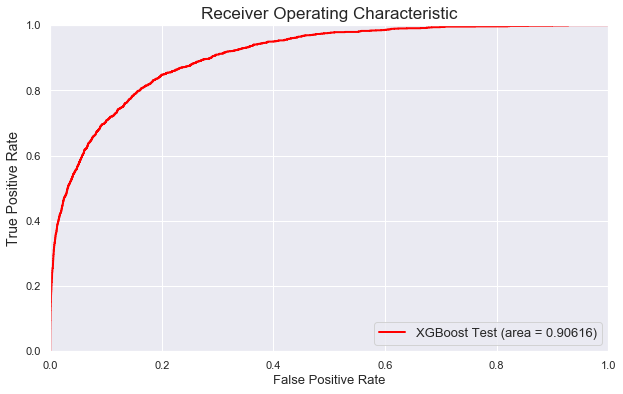

In [149]:
plt.figure(figsize=(10,6))

y_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='XGBoost Test (area = %0.5f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()


In [118]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
f_imp = []
for index in sorted_idx:
    f_imp.append([X.columns[index], model.feature_importances_[index]]) 


In [119]:
feature_importance = pd.DataFrame(f_imp)
feature_importance.columns = ['feature', 'importance']
zero_imp = list(feature_importance[feature_importance.importance <0.0001].feature.values)

In [120]:
zero_imp

['lymphoma_0',
 'lymphoma_1',
 'lymphoma_2',
 'leukemia_2',
 'leukemia_1',
 'solid_tumor_with_metastasis_0',
 'leukemia_0',
 'aids_0',
 'hospital_admit_source_Recovery Room',
 'diff_intubated_apache',
 'apache_3j_diagnosis_601.01',
 'apache_3j_diagnosis_408.02',
 'apache_3j_diagnosis_407.01',
 'apache_3j_diagnosis_405.01',
 'apache_3j_diagnosis_402.02',
 'apache_3j_diagnosis_402.01',
 'cirrhosis_1',
 'apache_3j_diagnosis_312.05',
 'apache_3j_diagnosis_311.01',
 'apache_3j_diagnosis_310.01',
 'apache_3j_diagnosis_307.02',
 'apache_3j_diagnosis_307.01',
 'apache_3j_diagnosis_305.01',
 'apache_3j_diagnosis_301.02',
 'apache_3j_diagnosis_301.01',
 'apache_3j_diagnosis_213.01',
 'apache_3j_diagnosis_212.02',
 'apache_3j_diagnosis_211.12',
 'apache_3j_diagnosis_211.1',
 'apache_3j_diagnosis_211.09',
 'apache_3j_diagnosis_211.08',
 'apache_3j_diagnosis_211.04',
 'apache_3j_diagnosis_211.03',
 'apache_3j_diagnosis_211.02',
 'apache_3j_diagnosis_501.04',
 'apache_3j_diagnosis_601.04',
 'apache_

In [121]:
feature_importance.head(50)

,feature,importance
0,apache_4a_icu_death_prob,0.075601
1,diff_ventilated_apache,0.030193
2,elective_surgery_2,0.027880
3,elective_surgery_1,0.019032
4,almost_dead,0.017917
5,d1_lactate_min,0.015939
6,apache_3j_diagnosis_102.01,0.010987
7,apache_3j_bodysystem_Metabolic,0.010246
8,d1_spo2_min,0.009932
9,gcs_verbal_apache,0.008223


In [122]:

X = X.drop(columns = zero_imp)
X_test = X_test.drop(columns = zero_imp)

In [123]:
from numpy import sort
thresholds = sort(model.feature_importances_)
thresholds

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
# plt.figure(figsize=(10,6))

# y_pred = model.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='XGBoost Test (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [ ]:
# plt.figure(figsize=(10,6))

# y_pred = model_ad.predict_proba(x_train_res)[:,1]
# fpr, tpr, thresholds = roc_curve(y_train_res, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [ ]:
# plt.figure(figsize=(10,6))

# y_pred = model_ad.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
         
# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# # pprint(random_grid)

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(random_state = 42)
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X, y)

In [ ]:
# train

In [ ]:

# from keras.models import Sequential
# from keras.layers import Dense
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.models import Model

In [ ]:
# model = Sequential()
# model.add(Dense(12, input_dim=201, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [ ]:
# METRICS = [keras.metrics.AUC(name='auc')]
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[METRICS])

In [ ]:
# model.fit(X, y, epochs=100, batch_size=64)

In [ ]:
# y_pred = model.predict(X)
# y_pred

In [ ]:
# plt.figure(figsize=(10,6))

# # y_pred = model.predict_proba(X)[:,1]
# fpr, tpr, thresholds = roc_curve(y, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))

# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [ ]:
# y_pred = model.predict(X_test)

In [ ]:
# plt.figure(figsize=(10,6))

# # y_pred = model.predict_proba(X)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))

# # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate', fontsize=13)
# plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic', fontsize=17)
# plt.legend(loc='lower right', fontsize=13)
# plt.show()

In [ ]:
# X_test.shape


In [ ]:
# y_pred = np.zeros(18343)

In [ ]:
# y_pred

In [ ]:
X['invasive_tests']

In [ ]:
# y_pred = X_test.apache_4a_icu_death_prob.fillna(0).values